## Dataset Class

In [6]:
import os
import os.path as osp

import networkx as nx
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import InMemoryDataset, DataLoader
from torch_geometric.utils import from_networkx

class MaxIndDataset(InMemoryDataset):
    def __init__(self, root):
        self.label_frame = pd.read_csv(osp.join(root, "label.csv"))
        self.weight_frame = pd.read_csv(osp.join(root, "weight.csv"))
        self.root_dir = root
        self.num_graphs = len(self.label_frame)
        super(MaxIndDataset, self).__init__(root)
        self.data, self.slices = torch.load(self.processed_paths[0])
   
    @property   
    def processed_file_names(self):
        return ['data.pt']
    
    def _download(self):
        pass
    
    def process(self):
        data_list = []
        for i in range(self.num_graphs):
            graph_name = os.path.join(self.root_dir, self.label_frame.iloc[i, 0])
            graph = nx.read_adjlist(graph_name, nodetype=int)
   
            weight = torch.tensor(self.weight_frame.iloc[i, 1:], dtype=torch.float)
            label = torch.tensor(self.label_frame.iloc[i, 1:], dtype=torch.long)
        
            data = from_networkx(graph)
            data.x = weight
            data.y = label
            
            data_list.append(data)
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

## Drawing Utility

Takes in a data entry:
* "edge_list" (list of edges)
* "x" labels (weights)
* "y" lables (output labels)

and draws the graph out in a circular format. 

In [7]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import torch
def draw_entry(entry, color_map = None):
    g = to_networkx(entry)
    
    if color_map:
        label = color_map
    else:
        label = entry["y"]
    
    # Create color map from selected nodes, green for selected, grey for unselected.
    color_map = ["grey"] * len(g.nodes)

    for i in np.flatnonzero(label):
        color_map[i] = "green"
        
    node_labels = entry["x"]
    
    if not torch.equal(node_labels, torch.ones(len(g.nodes))):
        node_labels = {k: "{0}:\n{1:.3f}".format(k, v) for (k, v) in enumerate(node_labels)}
    else:
        node_labels = {k: k for k in g.nodes}
    
    plt.figure()
    pos = nx.circular_layout(g)
    nx.draw(g, pos, node_size=2000, width = 1, node_color = color_map)
    nx.draw_networkx_labels(g, pos, node_labels)
    plt.show()  
    

In [8]:
def split_loader(dataset, train_size, test_size, batch_size):
    dataset.shuffle()
    size = len(dataset)
    
    tr_i = int(size * train_size)
    val_i = tr_i + int(size * test_size)
    train_loader = DataLoader(dataset[:tr_i], batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset[tr_i: val_i])
    test_loader = DataLoader(dataset[val_i:])
    return train_loader, val_loader, test_loader

In [9]:
visualize = MaxIndDataset('data/weighted_small')

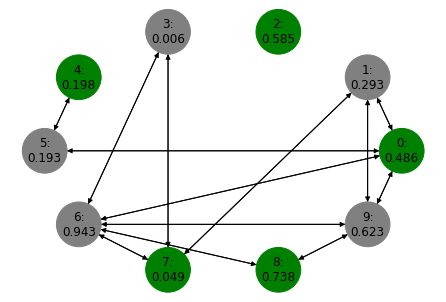

In [10]:
draw_entry(visualize[2])

In [11]:
bin_80 = MaxIndDataset('data/binomial_80')

In [12]:
train_loader, val_loader, test_loader = split_loader(bin_80, .7, .2, 20)

In [13]:

for b in train_loader:
    print(b)
    print(b.x.size())
    print(b.edge_index.size())
    break

Batch(batch=[1600], edge_index=[2, 25116], x=[1600], y=[1600])
torch.Size([1600])
torch.Size([2, 25116])


In [16]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class BasicNet(torch.nn.Module):
    def __init__(self):
        super(BasicNet, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        weight = data["x"].view(-1, 1)
        edge_index = data["edge_index"]
        x = self.conv1(weight, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.sigmoid(x)
        return x

In [17]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class MultiNet(torch.nn.Module):
    def __init__(self):
        super(MultiNet, self).__init__()
        self.conv_in = GCNConv(1, 32)
        self.conv_mid = GCNConv(32, 32)
        self.conv_out = GCNConv(32, 1)

    def forward(self, data):
        weight = data["x"].view(-1, 1)
        edge_index = data["edge_index"]
        x = self.conv_in(weight, edge_index)
        x = F.relu(x)
        
        x = self.conv_mid(x, edge_index)
        x = F.relu(x)
        
        x = self.conv_mid(x, edge_index)
        x = F.relu(x)
        
        x = self.conv_mid(x, edge_index)
        x = F.relu(x)
        
        x = self.conv_mid(x, edge_index)
        x = F.relu(x)
        
        x = self.conv_out(x, edge_index)
        x = torch.sigmoid(x)
        return x

In [18]:
from tqdm import tqdm#, tqdm_notebook

### Runs but losses dont go down, seems to converge to around 0.48

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MultiNet().to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train(epoch):
    model.train()
    running_loss = 0.0
    for i, item in enumerate(train_loader):
        optimizer.zero_grad()
        item = item.to(device)
        outputs = model(item)
        
        loss = criterion(outputs, item["y"].float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def evaluate(loader):
    model.eval()
    running_acc = 0.0 # Implement later
    running_loss = 0.0
    for i, item in enumerate(loader):
        item = item.to(device)
        outputs = model(item)
        loss = criterion(outputs.view(-1, 1), item["y"].float().view(-1, 1))
        running_loss += loss.item()
    return running_loss / len(loader)
        
for epoch in tqdm(range(15)):
    train_loss = train(epoch)
    val_loss = evaluate(val_loader)
    print(('Epoch: {:03d}, Train Loss: {:.4f}, Val Loss: {:.3f}').format(epoch, train_loss, val_loss))

print('Finished Training')        

  0%|          | 0/15 [00:00<?, ?it/s]/home/zach/anaconda3/envs/deepkidney/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([1600])) that is different to the input size (torch.Size([1600, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
  7%|▋         | 1/15 [00:10<02:25, 10.36s/it]

Epoch: 000, Train Loss: 0.5181, Val Loss: 0.509


 13%|█▎        | 2/15 [00:20<02:13, 10.28s/it]

Epoch: 001, Train Loss: 0.5006, Val Loss: 0.495


 20%|██        | 3/15 [00:30<02:01, 10.14s/it]

Epoch: 002, Train Loss: 0.4843, Val Loss: 0.476


 27%|██▋       | 4/15 [00:40<01:50, 10.04s/it]

Epoch: 003, Train Loss: 0.4663, Val Loss: 0.458


 33%|███▎      | 5/15 [00:49<01:39,  9.98s/it]

Epoch: 004, Train Loss: 0.4538, Val Loss: 0.452


 40%|████      | 6/15 [00:59<01:29,  9.95s/it]

Epoch: 005, Train Loss: 0.4529, Val Loss: 0.441


 47%|████▋     | 7/15 [01:10<01:20, 10.03s/it]

Epoch: 006, Train Loss: 0.4443, Val Loss: 0.439


 53%|█████▎    | 8/15 [01:19<01:09,  9.98s/it]

Epoch: 007, Train Loss: 0.4446, Val Loss: 0.447


 60%|██████    | 9/15 [01:29<00:59,  9.94s/it]

Epoch: 008, Train Loss: 0.4448, Val Loss: 0.441


 67%|██████▋   | 10/15 [01:39<00:49,  9.93s/it]

Epoch: 009, Train Loss: 0.4363, Val Loss: 0.425


 73%|███████▎  | 11/15 [01:49<00:39,  9.89s/it]

Epoch: 010, Train Loss: 0.4295, Val Loss: 0.421


 80%|████████  | 12/15 [01:59<00:29,  9.88s/it]

Epoch: 011, Train Loss: 0.4293, Val Loss: 0.421


 87%|████████▋ | 13/15 [02:09<00:19,  9.85s/it]

Epoch: 012, Train Loss: 0.4288, Val Loss: 0.429


 93%|█████████▎| 14/15 [02:18<00:09,  9.85s/it]

Epoch: 013, Train Loss: 0.4236, Val Loss: 0.416


100%|██████████| 15/15 [02:28<00:00,  9.86s/it]

Epoch: 014, Train Loss: 0.4223, Val Loss: 0.416
Finished Training


In [21]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv_in.weight 	 torch.Size([1, 32])
conv_in.bias 	 torch.Size([32])
conv_mid.weight 	 torch.Size([32, 32])
conv_mid.bias 	 torch.Size([32])
conv_out.weight 	 torch.Size([32, 1])
conv_out.bias 	 torch.Size([1])


In [22]:
torch.save(model.state_dict(), "model/unweighted_multinet.pt")

In [23]:
model.eval()

MultiNet(
  (conv_in): GCNConv(1, 32)
  (conv_mid): GCNConv(32, 32)
  (conv_out): GCNConv(32, 1)
)

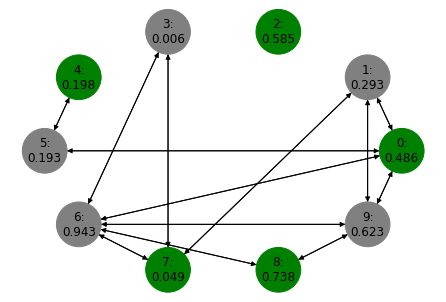

In [24]:
test_item = visualize[2]
draw_entry(test_item)

In [25]:
test_item.to(device)
out = model(test_item)
out

tensor([[0.9463],
        [0.9512],
        [0.9263],
        [0.9601],
        [0.9565],
        [0.9474],
        [0.8995],
        [0.9421],
        [0.9622],
        [0.9326]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [26]:
# Sorts the indices from greatest value to the least
ans = np.flip(out.detach().cpu().numpy().T.argsort())
ans

array([[8, 3, 4, 1, 5, 0, 7, 9, 2, 6]])

In [27]:
edges = test_item["edge_index"].cpu().numpy().T
edges

array([[0, 1],
       [0, 5],
       [0, 6],
       [0, 9],
       [1, 0],
       [1, 7],
       [1, 9],
       [5, 0],
       [5, 4],
       [6, 0],
       [6, 3],
       [6, 7],
       [6, 8],
       [6, 9],
       [9, 0],
       [9, 1],
       [9, 6],
       [9, 8],
       [7, 1],
       [7, 3],
       [7, 6],
       [3, 6],
       [3, 7],
       [4, 5],
       [8, 6],
       [8, 9]])

In [28]:
for e in edges:
    print(e)

[0 1]
[0 5]
[0 6]
[0 9]
[1 0]
[1 7]
[1 9]
[5 0]
[5 4]
[6 0]
[6 3]
[6 7]
[6 8]
[6 9]
[9 0]
[9 1]
[9 6]
[9 8]
[7 1]
[7 3]
[7 6]
[3 6]
[3 7]
[4 5]
[8 6]
[8 9]


In [34]:
edges[:, 0] != 3

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True])

In [35]:
edges[:, 1] != 3

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True])

In [36]:
np.logical_and(edges[:, 0] != 3, edges[:, 1] != 3)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False, False,  True,  True,  True])

In [43]:
edges[(edges[:, 0] != 3) & (edges[:, 1] != 3)]

array([[0, 1],
       [0, 5],
       [0, 6],
       [0, 9],
       [1, 0],
       [1, 7],
       [1, 9],
       [5, 0],
       [5, 4],
       [6, 0],
       [6, 7],
       [6, 8],
       [6, 9],
       [9, 0],
       [9, 1],
       [9, 6],
       [9, 8],
       [7, 1],
       [7, 6],
       [4, 5],
       [8, 6],
       [8, 9]])